In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
import plotly.offline as pyo
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# !pip install interpret
# from interpret.blackbox import LimeTabular
# from interpret import show

import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer
import graphviz
import shap

import pickle

import warnings
warnings.filterwarnings("ignore")

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input/ids-intrusion-csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ids-intrusion-csv/02-28-2018.csv
/kaggle/input/ids-intrusion-csv/03-01-2018.csv
/kaggle/input/ids-intrusion-csv/02-16-2018.csv
/kaggle/input/ids-intrusion-csv/02-15-2018.csv
/kaggle/input/ids-intrusion-csv/02-21-2018.csv
/kaggle/input/ids-intrusion-csv/03-02-2018.csv
/kaggle/input/ids-intrusion-csv/02-22-2018.csv
/kaggle/input/ids-intrusion-csv/02-20-2018.csv
/kaggle/input/ids-intrusion-csv/02-14-2018.csv
/kaggle/input/ids-intrusion-csv/02-23-2018.csv


In [5]:
%%time
network_data_d1 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-14-2018.csv", low_memory=False)
network_data_d2 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-15-2018.csv", low_memory=False)
network_data_d3 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-16-2018.csv", low_memory=False)
network_data_d4 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-20-2018.csv", low_memory=False)
network_data_d5 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-21-2018.csv", low_memory=False)
network_data_d6 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-22-2018.csv", low_memory=False)
network_data_d7 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-23-2018.csv", low_memory=False)
network_data_d8 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-28-2018.csv", low_memory=False)
network_data_d9 = pd.read_csv("/kaggle/input/ids-intrusion-csv/03-01-2018.csv", low_memory=False)
network_data_d10 = pd.read_csv("/kaggle/input/ids-intrusion-csv/03-02-2018.csv", low_memory=False)

CPU times: user 3min 46s, sys: 32.1 s, total: 4min 18s
Wall time: 5min 2s


In [6]:
network_data_d4.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP'], axis=1,inplace=True)

In [7]:
def fixDataType(df_dataset):
    
    df_dataset = df_dataset[df_dataset['Dst Port'] != 'Dst Port']
    
    df_dataset['Dst Port'] = df_dataset['Dst Port'].astype(int)
    df_dataset['Protocol'] = df_dataset['Protocol'].astype(int)
    df_dataset['Flow Duration'] = df_dataset['Flow Duration'].astype(int)
    df_dataset['Tot Fwd Pkts'] = df_dataset['Tot Fwd Pkts'].astype(int)
    df_dataset['Tot Bwd Pkts'] = df_dataset['Tot Bwd Pkts'].astype(int)
    df_dataset['TotLen Fwd Pkts'] = df_dataset['TotLen Fwd Pkts'].astype(int)
    df_dataset['TotLen Bwd Pkts'] = df_dataset['TotLen Bwd Pkts'].astype(int)
    df_dataset['Fwd Pkt Len Max'] = df_dataset['Fwd Pkt Len Max'].astype(int)
    df_dataset['Fwd Pkt Len Min'] = df_dataset['Fwd Pkt Len Min'].astype(int)
    df_dataset['Fwd Pkt Len Mean'] = df_dataset['Fwd Pkt Len Mean'].astype(float)
    df_dataset['Fwd Pkt Len Std'] = df_dataset['Fwd Pkt Len Std'].astype(float)
    df_dataset['Bwd Pkt Len Max'] = df_dataset['Bwd Pkt Len Max'].astype(int)
    df_dataset['Bwd Pkt Len Min'] = df_dataset['Bwd Pkt Len Min'].astype(int)
    df_dataset['Bwd Pkt Len Mean'] = df_dataset['Bwd Pkt Len Mean'].astype(float)
    df_dataset['Bwd Pkt Len Std'] = df_dataset['Bwd Pkt Len Std'].astype(float)
    df_dataset['Flow Byts/s'] = df_dataset['Flow Byts/s'].astype(float)
    df_dataset['Flow Pkts/s'] = df_dataset['Flow Pkts/s'].astype(float)
    df_dataset['Flow IAT Mean'] = df_dataset['Flow IAT Mean'].astype(float)
    df_dataset['Flow IAT Std'] = df_dataset['Flow IAT Std'].astype(float)
    df_dataset['Flow IAT Max'] = df_dataset['Flow IAT Max'].astype(int)
    df_dataset['Flow IAT Min'] = df_dataset['Flow IAT Min'].astype(int)
    df_dataset['Fwd IAT Tot'] = df_dataset['Fwd IAT Tot'].astype(int)
    df_dataset['Fwd IAT Mean'] = df_dataset['Fwd IAT Mean'].astype(float)
    df_dataset['Fwd IAT Std'] = df_dataset['Fwd IAT Std'].astype(float)
    df_dataset['Fwd IAT Max'] = df_dataset['Fwd IAT Max'].astype(int)
    df_dataset['Fwd IAT Min'] = df_dataset['Fwd IAT Min'].astype(int)
    df_dataset['Bwd IAT Tot'] = df_dataset['Bwd IAT Tot'].astype(int)
    df_dataset['Bwd IAT Mean'] = df_dataset['Bwd IAT Mean'].astype(float)
    df_dataset['Bwd IAT Std'] = df_dataset['Bwd IAT Std'].astype(float)
    df_dataset['Bwd IAT Max'] = df_dataset['Bwd IAT Max'].astype(int)
    df_dataset['Bwd IAT Min'] = df_dataset['Bwd IAT Min'].astype(int)
    df_dataset['Fwd PSH Flags'] = df_dataset['Fwd PSH Flags'].astype(int)
    df_dataset['Bwd PSH Flags'] = df_dataset['Bwd PSH Flags'].astype(int)
    df_dataset['Fwd URG Flags'] = df_dataset['Fwd URG Flags'].astype(int)
    df_dataset['Bwd URG Flags'] = df_dataset['Bwd URG Flags'].astype(int)
    df_dataset['Fwd Header Len'] = df_dataset['Fwd Header Len'].astype(int)
    df_dataset['Bwd Header Len'] = df_dataset['Bwd Header Len'].astype(int)
    df_dataset['Fwd Pkts/s'] = df_dataset['Fwd Pkts/s'].astype(float)
    df_dataset['Bwd Pkts/s'] = df_dataset['Bwd Pkts/s'].astype(float)
    df_dataset['Pkt Len Min'] = df_dataset['Pkt Len Min'].astype(int)
    df_dataset['Pkt Len Max'] = df_dataset['Pkt Len Max'].astype(int)
    df_dataset['Pkt Len Mean'] = df_dataset['Pkt Len Mean'].astype(float)
    df_dataset['Pkt Len Std'] = df_dataset['Pkt Len Std'].astype(float)
    df_dataset['Pkt Len Var'] = df_dataset['Pkt Len Var'].astype(float)
    df_dataset['FIN Flag Cnt'] = df_dataset['FIN Flag Cnt'].astype(int)
    df_dataset['SYN Flag Cnt'] = df_dataset['SYN Flag Cnt'].astype(int)
    df_dataset['RST Flag Cnt'] = df_dataset['RST Flag Cnt'].astype(int)
    df_dataset['PSH Flag Cnt'] = df_dataset['PSH Flag Cnt'].astype(int)
    df_dataset['ACK Flag Cnt'] = df_dataset['ACK Flag Cnt'].astype(int)
    df_dataset['URG Flag Cnt'] = df_dataset['URG Flag Cnt'].astype(int)
    df_dataset['CWE Flag Count'] = df_dataset['CWE Flag Count'].astype(int)
    df_dataset['ECE Flag Cnt'] = df_dataset['ECE Flag Cnt'].astype(int)
    df_dataset['Down/Up Ratio'] = df_dataset['Down/Up Ratio'].astype(int)
    df_dataset['Pkt Size Avg'] = df_dataset['Pkt Size Avg'].astype(float)
    df_dataset['Fwd Seg Size Avg'] = df_dataset['Fwd Seg Size Avg'].astype(float)
    df_dataset['Bwd Seg Size Avg'] = df_dataset['Bwd Seg Size Avg'].astype(float)
    df_dataset['Fwd Byts/b Avg'] = df_dataset['Fwd Byts/b Avg'].astype(int)
    df_dataset['Fwd Pkts/b Avg'] = df_dataset['Fwd Pkts/b Avg'].astype(int)
    df_dataset['Fwd Blk Rate Avg'] = df_dataset['Fwd Blk Rate Avg'].astype(int)
    df_dataset['Bwd Byts/b Avg'] = df_dataset['Bwd Byts/b Avg'].astype(int)
    df_dataset['Bwd Pkts/b Avg'] = df_dataset['Bwd Pkts/b Avg'].astype(int)
    df_dataset['Bwd Blk Rate Avg'] = df_dataset['Bwd Blk Rate Avg'].astype(int)
    df_dataset['Subflow Fwd Pkts'] = df_dataset['Subflow Fwd Pkts'].astype(int)
    df_dataset['Subflow Fwd Byts'] = df_dataset['Subflow Fwd Byts'].astype(int)
    df_dataset['Subflow Bwd Pkts'] = df_dataset['Subflow Bwd Pkts'].astype(int)
    df_dataset['Subflow Bwd Byts'] = df_dataset['Subflow Bwd Byts'].astype(int)
    df_dataset['Init Fwd Win Byts'] = df_dataset['Init Fwd Win Byts'].astype(int)
    df_dataset['Init Bwd Win Byts'] = df_dataset['Init Bwd Win Byts'].astype(int)
    df_dataset['Fwd Act Data Pkts'] = df_dataset['Fwd Act Data Pkts'].astype(int)
    df_dataset['Fwd Seg Size Min'] = df_dataset['Fwd Seg Size Min'].astype(int)
    df_dataset['Active Mean'] = df_dataset['Active Mean'].astype(float)
    df_dataset['Active Std'] = df_dataset['Active Std'].astype(float)
    df_dataset['Active Max'] = df_dataset['Active Max'].astype(int)
    df_dataset['Active Min'] = df_dataset['Active Min'].astype(int)
    df_dataset['Idle Mean'] = df_dataset['Idle Mean'].astype(float)
    df_dataset['Idle Std'] = df_dataset['Idle Std'].astype(float)
    df_dataset['Idle Max'] = df_dataset['Idle Max'].astype(int)
    df_dataset['Idle Min'] = df_dataset['Idle Min'].astype(int)
    
    return df_dataset

In [9]:
network_data_d1 = fixDataType(network_data_d1)
network_data_d2 = fixDataType(network_data_d2)
network_data_d3 = fixDataType(network_data_d3)
network_data_d4 = fixDataType(network_data_d4)
network_data_d5 = fixDataType(network_data_d5)
network_data_d6 = fixDataType(network_data_d6)
network_data_d7 = fixDataType(network_data_d7)
network_data_d8 = fixDataType(network_data_d8)
network_data_d9 = fixDataType(network_data_d9)
network_data_d10 = fixDataType(network_data_d10)

In [11]:
def dataProperties(df, day):
    print(day)
    df.shape
    print(df)
    print(df.info())
    print("========================")

In [11]:
dataProperties(network_data_d1, "Day 1")
dataProperties(network_data_d2, "Day 2")
dataProperties(network_data_d3, "Day 3")
dataProperties(network_data_d4, "Day 4")
dataProperties(network_data_d5, "Day 5")
dataProperties(network_data_d6, "Day 6")
dataProperties(network_data_d7, "Day 7")
dataProperties(network_data_d8, "Day 8")
dataProperties(network_data_d9, "Day 9")
dataProperties(network_data_d10, "Day 10")

Day 1
         Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
0               0         0  14/02/2018 08:31:01      112641719             3   
1               0         0  14/02/2018 08:33:50      112641466             3   
2               0         0  14/02/2018 08:36:39      112638623             3   
3              22         6  14/02/2018 08:40:13        6453966            15   
4              22         6  14/02/2018 08:40:23        8804066            14   
...           ...       ...                  ...            ...           ...   
1048570        80         6  14/02/2018 10:53:23       10156986             5   
1048571        80         6  14/02/2018 10:53:33            117             2   
1048572        80         6  14/02/2018 10:53:28        5095331             3   
1048573        80         6  14/02/2018 10:53:28        5235511             3   
1048574       443         6  14/02/2018 10:53:28        5807256             6   

         Tot Bwd Pkts

In [16]:
def visualizeBar(df):
    # bar chart of packets label
    plt.figure(figsize=(10, 5))
    plt.title('Packet Distribution')
    # plt.bar(x=['Benign', 'FTP-BruteForce', 'SSH-Bruteforce'], height=network_data['Label'].value_counts(), color=['blue', 'magenta', 'cyan'])
    plt.bar(x=df['Label'].unique(), height=df['Label'].value_counts())
    p = plt.gcf()

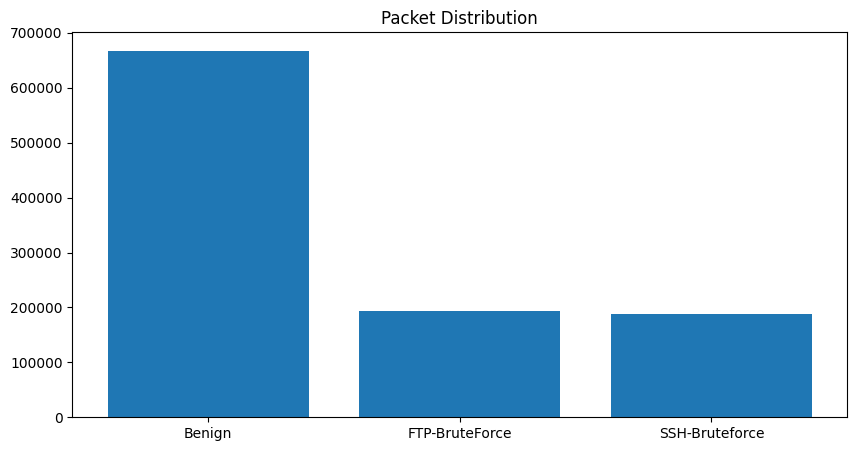

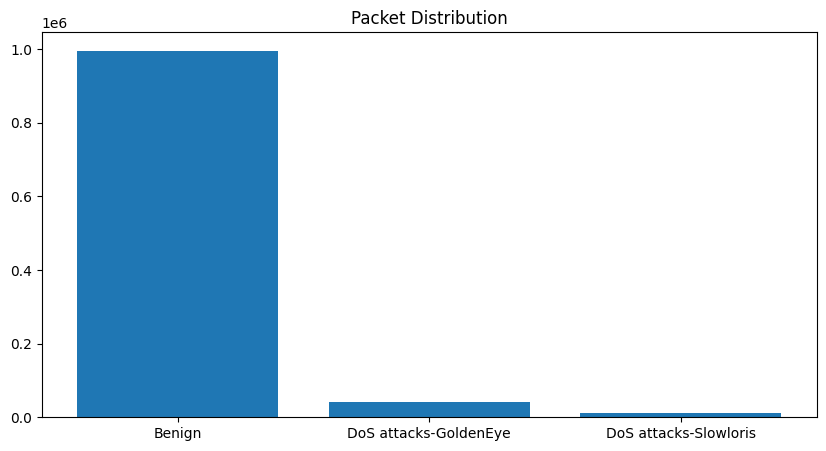

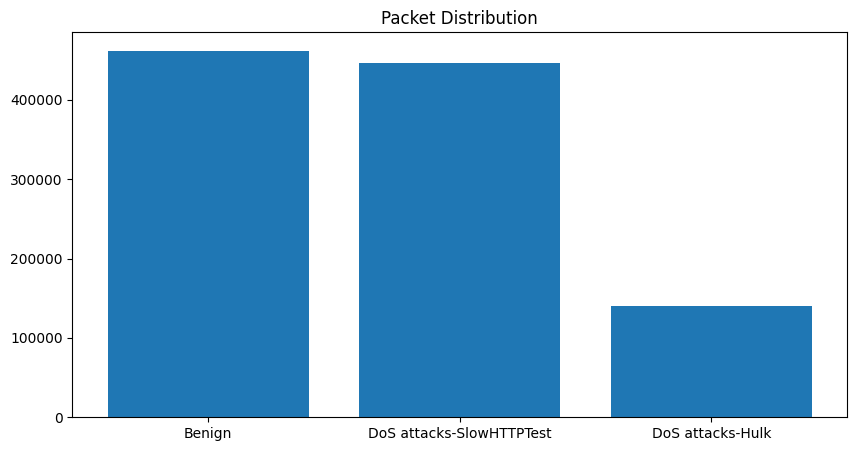

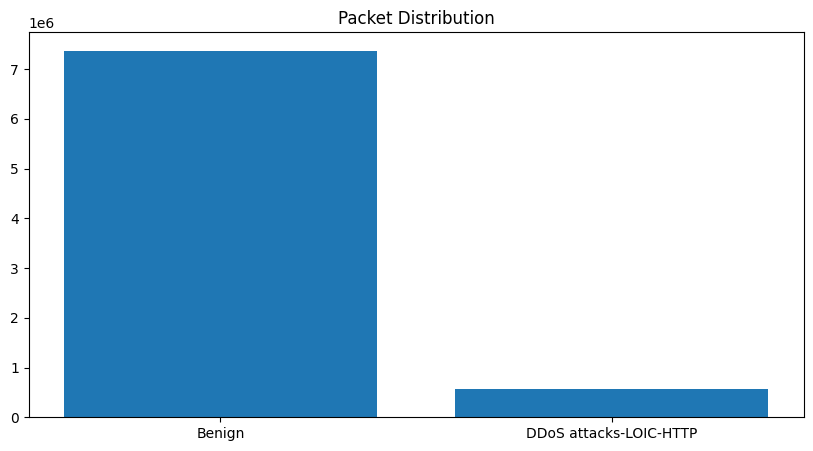

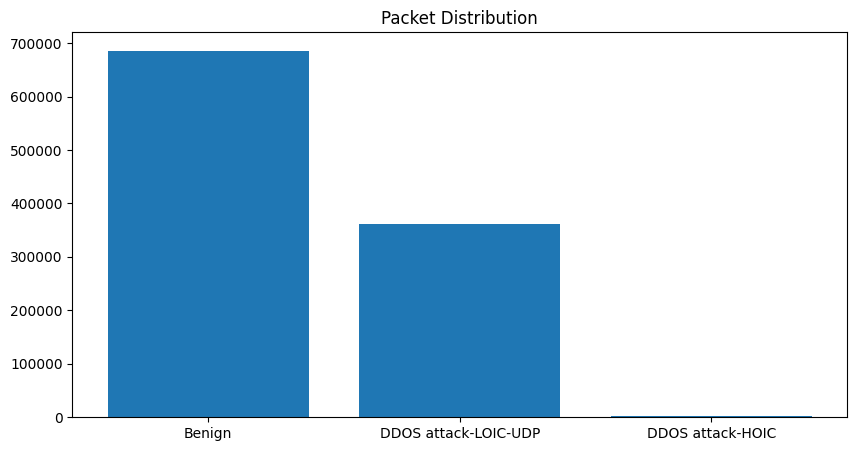

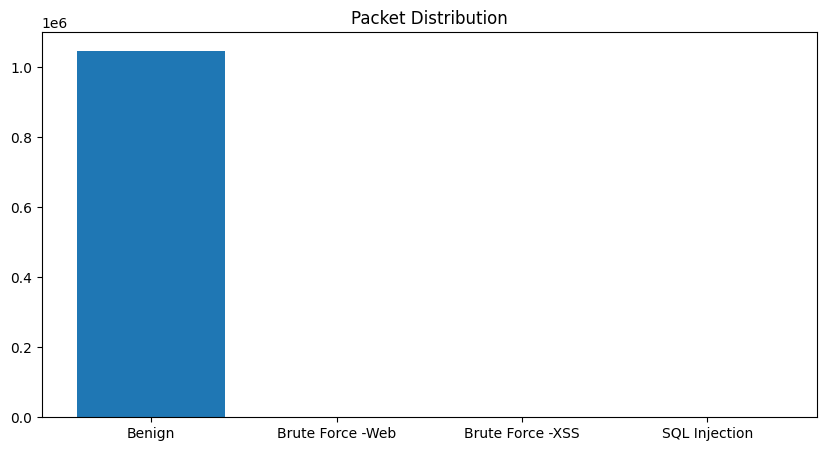

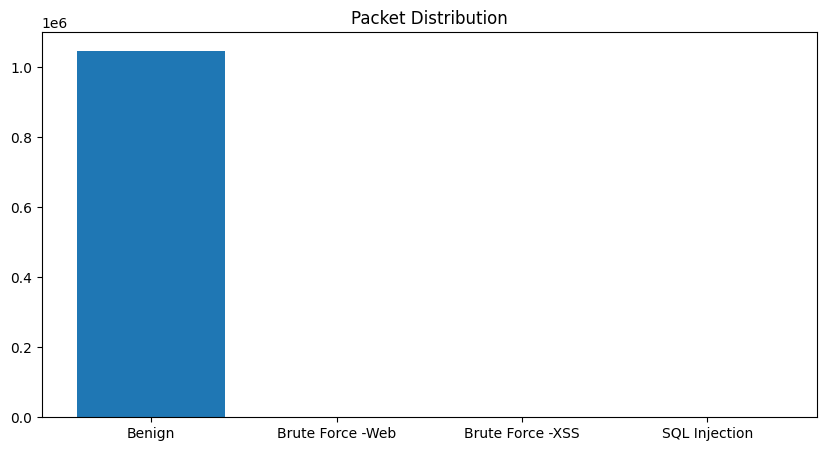

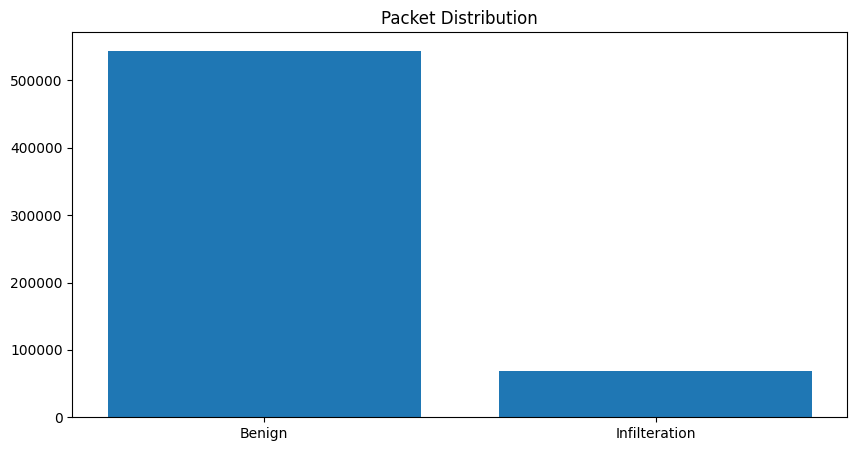

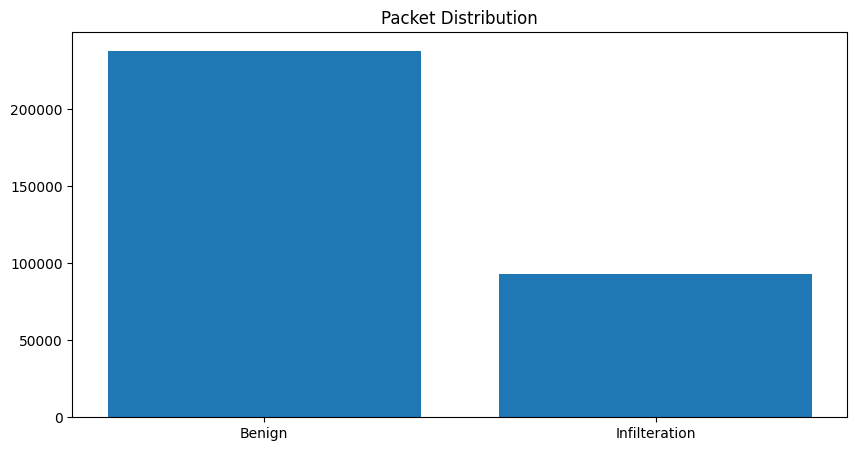

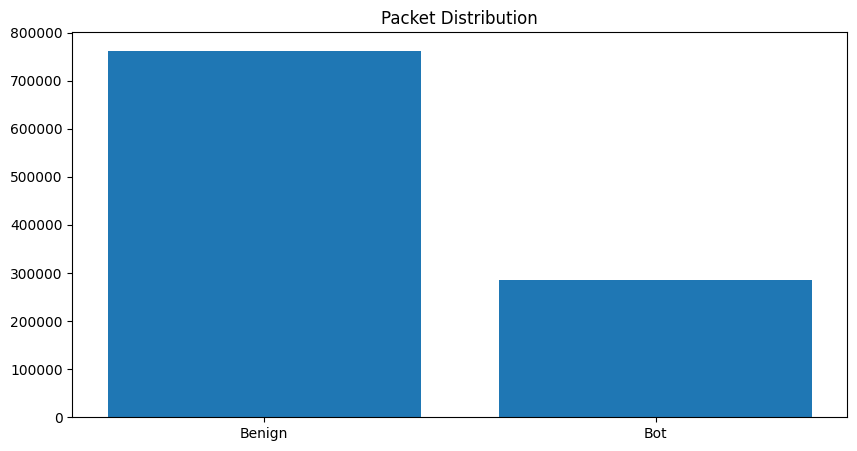

In [17]:
visualizeBar(network_data_d1)
visualizeBar(network_data_d2)
visualizeBar(network_data_d3)
visualizeBar(network_data_d4)
visualizeBar(network_data_d5)
visualizeBar(network_data_d6)
visualizeBar(network_data_d7)
visualizeBar(network_data_d8)
visualizeBar(network_data_d9)
visualizeBar(network_data_d10)

In [12]:
def dropInfinateNull(df):
    print (df.shape)

    # replace infinity value as null value
    df = df.replace(["Infinity", "infinity"], np.inf)
    df = df.replace([np.inf, -np.inf], np.nan)

    # drop all null values
    df.dropna(inplace=True)

    print (df.shape)
    
    return df

In [13]:
network_data_d1 = dropInfinateNull(network_data_d1)
network_data_d2 = dropInfinateNull(network_data_d2)
network_data_d3 = dropInfinateNull(network_data_d3)
network_data_d4 = dropInfinateNull(network_data_d4)
network_data_d5 = dropInfinateNull(network_data_d5)
network_data_d6 = dropInfinateNull(network_data_d6)
network_data_d7 = dropInfinateNull(network_data_d7)
network_data_d8 = dropInfinateNull(network_data_d8)
network_data_d9 = dropInfinateNull(network_data_d9)
network_data_d10 = dropInfinateNull(network_data_d10)

(1048575, 80)
(1044751, 80)
(1048575, 80)
(1040548, 80)
(1048574, 80)
(1048574, 80)
(7948748, 80)
(7889295, 80)
(1048575, 80)
(1048575, 80)
(1048575, 80)
(1042965, 80)
(1048575, 80)
(1042867, 80)
(613071, 80)
(606902, 80)
(331100, 80)
(328181, 80)
(1048575, 80)
(1044525, 80)


In [14]:
def dropUnnecessaryColumn(df): 
    df.drop(columns="Timestamp", inplace=True)
    print (df.shape)
    return df

In [15]:
network_data_d1 = dropUnnecessaryColumn(network_data_d1)
network_data_d2 = dropUnnecessaryColumn(network_data_d2)
network_data_d3 = dropUnnecessaryColumn(network_data_d3)
network_data_d4 = dropUnnecessaryColumn(network_data_d4)
network_data_d5 = dropUnnecessaryColumn(network_data_d5)
network_data_d6 = dropUnnecessaryColumn(network_data_d6)
network_data_d7 = dropUnnecessaryColumn(network_data_d7)
network_data_d8 = dropUnnecessaryColumn(network_data_d8)
network_data_d9 = dropUnnecessaryColumn(network_data_d9)
network_data_d10 = dropUnnecessaryColumn(network_data_d10)

(1044751, 79)
(1040548, 79)
(1048574, 79)
(7889295, 79)
(1048575, 79)
(1042965, 79)
(1042867, 79)
(606902, 79)
(328181, 79)
(1044525, 79)


In [16]:
network_data = pd.concat([network_data_d1, network_data_d2], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d1, network_data_d2

network_data = pd.concat([network_data, network_data_d3], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d3

network_data = pd.concat([network_data, network_data_d4], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d4

network_data = pd.concat([network_data, network_data_d5], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d5

network_data = pd.concat([network_data, network_data_d6], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d6

network_data = pd.concat([network_data, network_data_d7], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d7

network_data = pd.concat([network_data, network_data_d8], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d8

network_data = pd.concat([network_data, network_data_d9], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d9

network_data = pd.concat([network_data, network_data_d10], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d10

In [17]:
print(network_data['Label'].value_counts())

Label
Benign                      13390249
DDOS attack-HOIC              686012
DDoS attacks-LOIC-HTTP        576191
DoS attacks-Hulk              461912
Bot                           286191
FTP-BruteForce                193354
SSH-Bruteforce                187589
Infilteration                 160639
DoS attacks-SlowHTTPTest      139890
DoS attacks-GoldenEye          41508
DoS attacks-Slowloris          10990
DDOS attack-LOIC-UDP            1730
Brute Force -Web                 611
Brute Force -XSS                 230
SQL Injection                     87
Name: count, dtype: int64


In [18]:
# Sample 40,000 records for each label
sampled_data = network_data.groupby('Label').apply(lambda x: x.sample(n=min(10500, len(x)), random_state=1))

# Reset the index of the sampled data
sampled_data = sampled_data.reset_index(drop=True)
print(f"Total records in the sampled dataset: {len(sampled_data)}")

network_data = sampled_data

Total records in the sampled dataset: 118158


In [19]:
print(network_data['Label'].value_counts())

Label
Benign                      10500
Bot                         10500
DDOS attack-HOIC            10500
DDoS attacks-LOIC-HTTP      10500
DoS attacks-SlowHTTPTest    10500
DoS attacks-Hulk            10500
DoS attacks-GoldenEye       10500
FTP-BruteForce              10500
Infilteration               10500
SSH-Bruteforce              10500
DoS attacks-Slowloris       10500
DDOS attack-LOIC-UDP         1730
Brute Force -Web              611
Brute Force -XSS              230
SQL Injection                  87
Name: count, dtype: int64


In [20]:
# Assuming network_data is your original DataFrame
# Define the labels to be dropped
labels_to_drop = [
    "DDOS attack-LOIC-UDP",
    "Brute Force -Web",
    "Brute Force -XSS",
    "SQL Injection"
]

# Drop records where "Label" is in labels_to_drop
network_data = network_data[~network_data['Label'].isin(labels_to_drop)]

In [21]:
print(network_data['Label'].value_counts())

Label
Benign                      10500
Bot                         10500
DDOS attack-HOIC            10500
DDoS attacks-LOIC-HTTP      10500
DoS attacks-GoldenEye       10500
DoS attacks-Hulk            10500
DoS attacks-SlowHTTPTest    10500
DoS attacks-Slowloris       10500
FTP-BruteForce              10500
Infilteration               10500
SSH-Bruteforce              10500
Name: count, dtype: int64


In [22]:
# drop the constant columns (which varience is 0)
variances = network_data.var(numeric_only=True)
constant_columns = variances[variances == 0].index
network_data = network_data.drop(constant_columns, axis=1)

print(constant_columns)
print (network_data.shape)

Index(['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg',
       'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg',
       'Bwd Blk Rate Avg'],
      dtype='object')
(115500, 71)


In [23]:
duplicates = set()
for i in range(0, len(network_data.columns)):
    col1 = network_data.columns[i]
    for j in range(i+1, len(network_data.columns)):
        col2 = network_data.columns[j]
        if(network_data[col1].equals(network_data[col2])):
            duplicates.add(col2)

print (duplicates)
network_data.drop(duplicates, axis=1, inplace=True)
print (network_data.shape)

{'CWE Flag Count', 'SYN Flag Cnt', 'Subflow Fwd Byts', 'ECE Flag Cnt', 'Subflow Bwd Byts', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts'}
(115500, 64)


In [24]:
# encode the target feature
label_encoder = LabelEncoder()

network_data['Label'] = label_encoder.fit_transform(network_data['Label'])
attack_types = label_encoder.classes_
attack_encodings = label_encoder.transform(attack_types)

attack_mapping = dict(zip(attack_types, attack_encodings))

for attack, encoding in attack_mapping.items():
    print(f"{attack}: {encoding}")

Benign: 0
Bot: 1
DDOS attack-HOIC: 2
DDoS attacks-LOIC-HTTP: 3
DoS attacks-GoldenEye: 4
DoS attacks-Hulk: 5
DoS attacks-SlowHTTPTest: 6
DoS attacks-Slowloris: 7
FTP-BruteForce: 8
Infilteration: 9
SSH-Bruteforce: 10


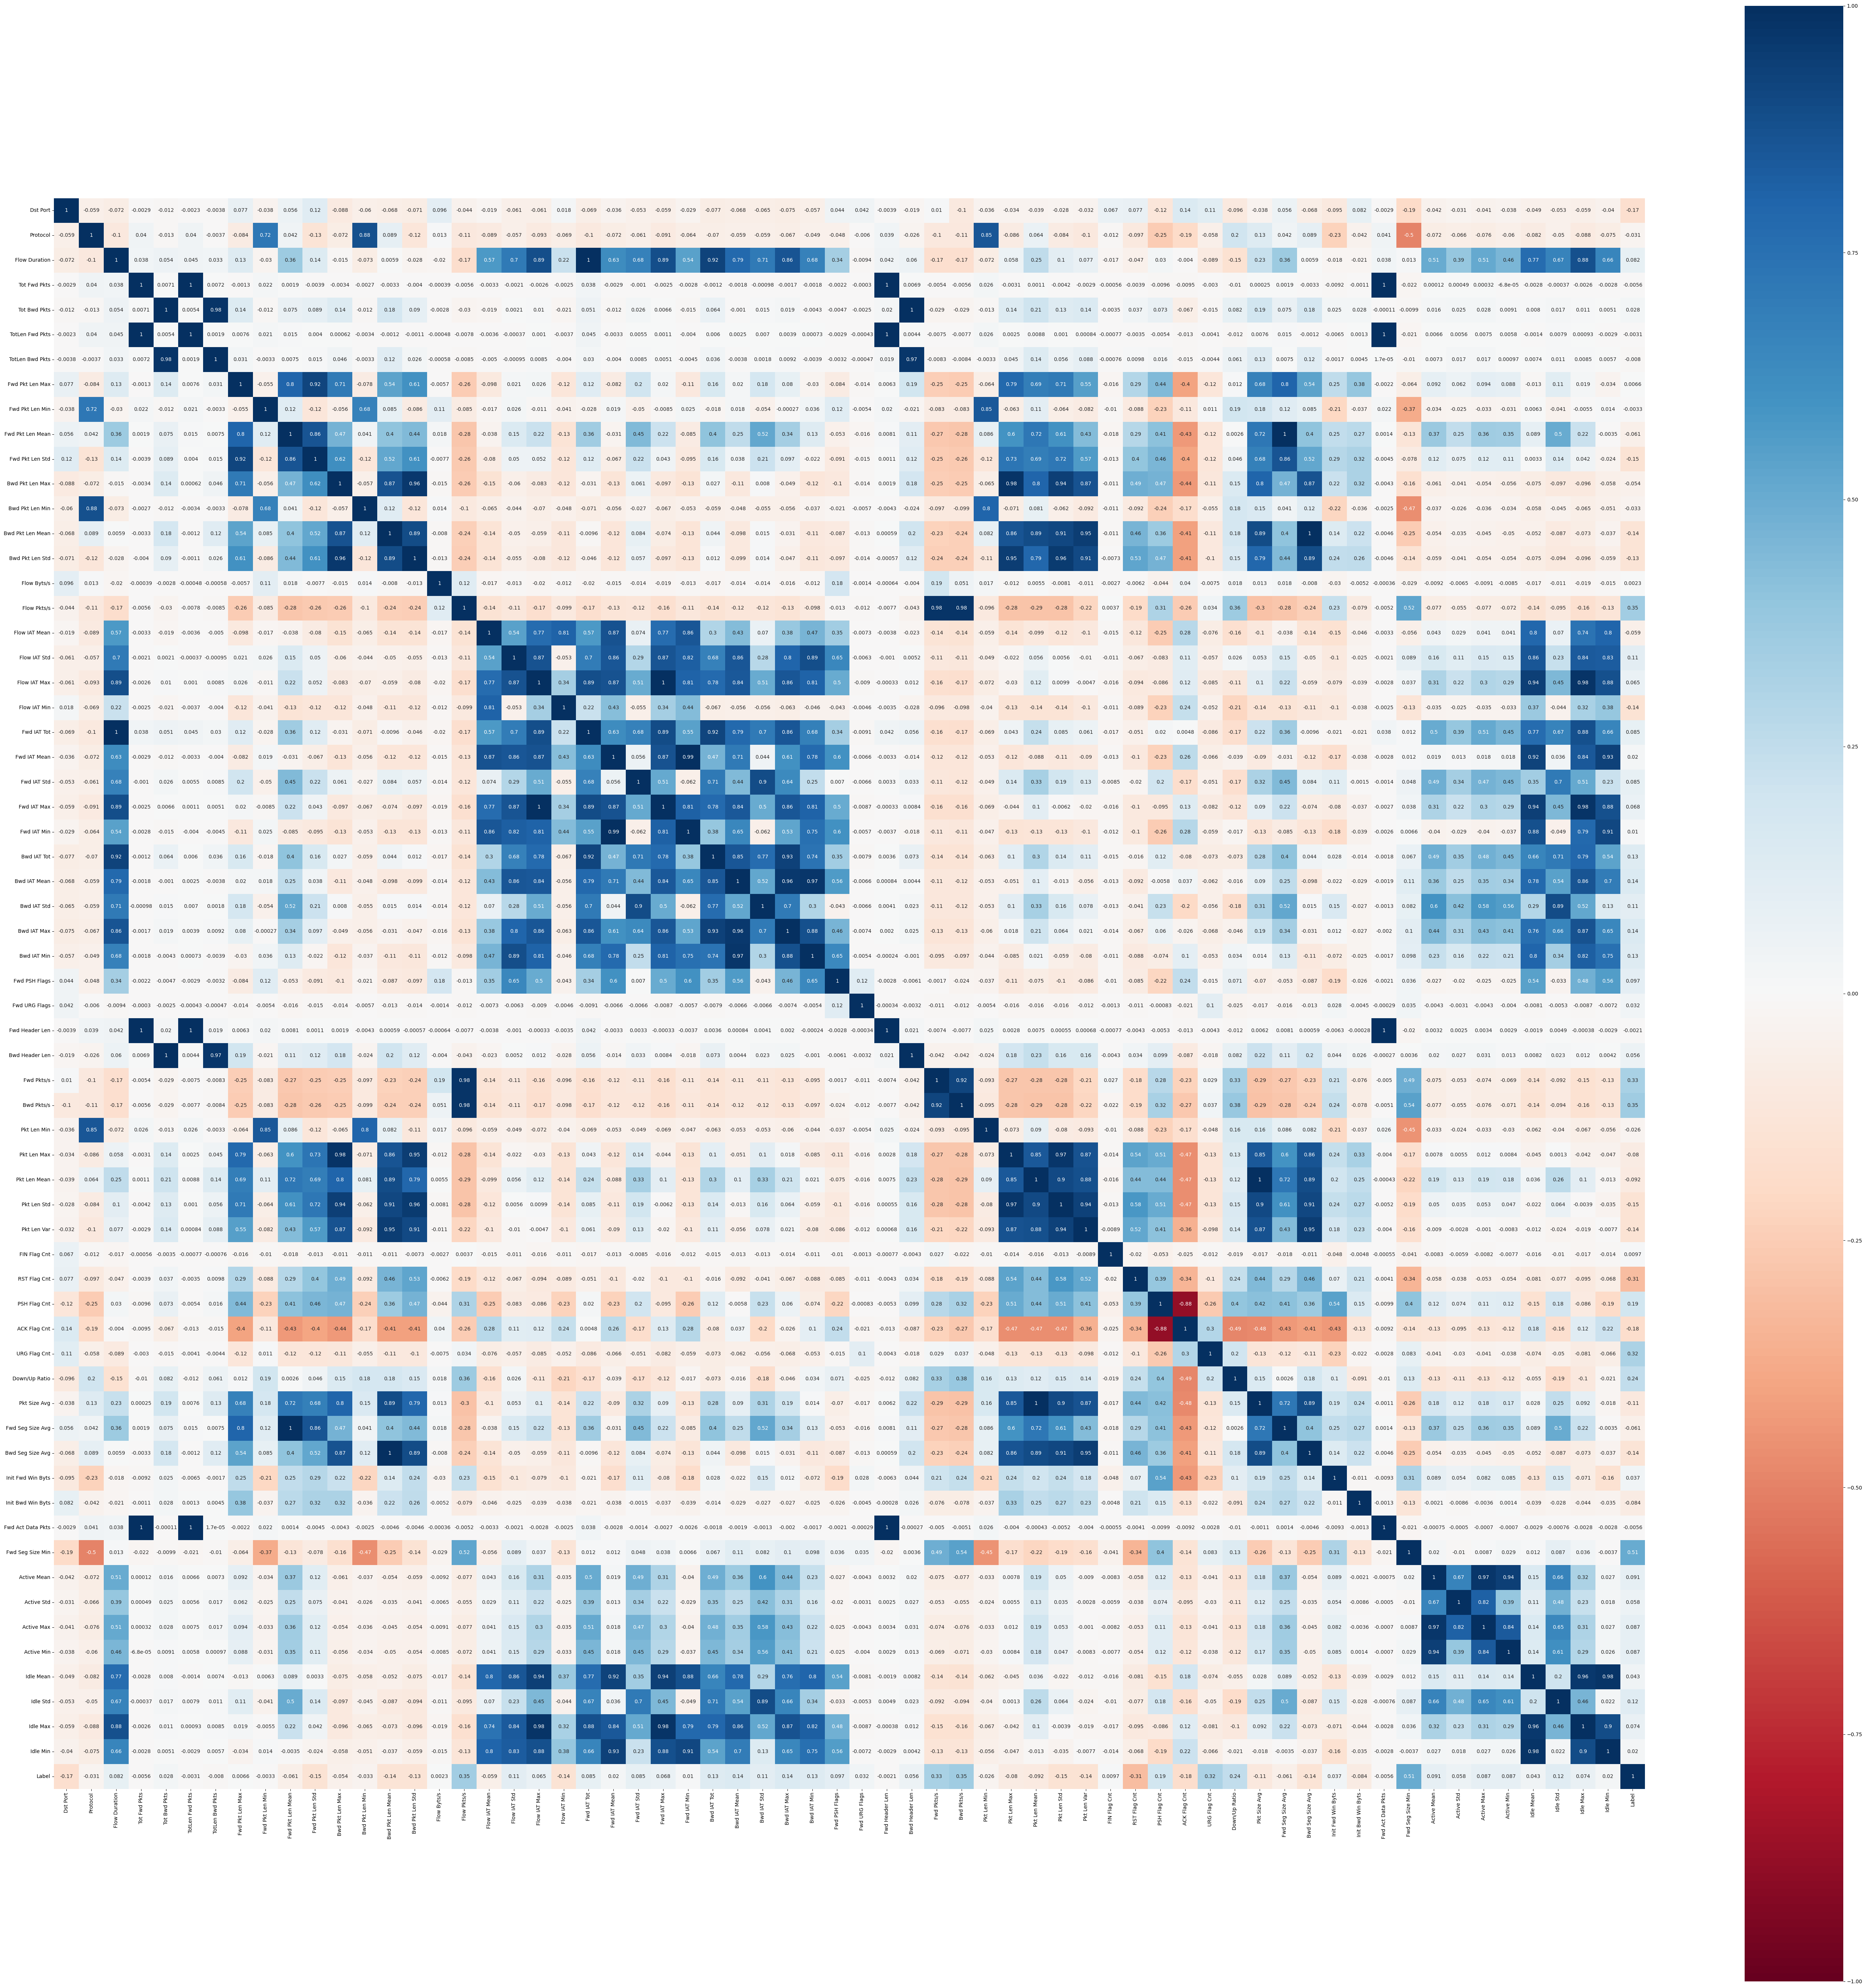

In [25]:
# pearson correlation heatmap
plt.figure(figsize=(70, 70))
corr = network_data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, square=True) # annot=True
plt.show()

In [26]:
correlated_col = set()
is_correlated = [True] * len(corr.columns)
threshold = 0.90
for i in range (len(corr.columns)):
    if(is_correlated[i]):
        for j in range(i):
          if (corr.iloc[i, j] >= threshold) and (is_correlated[j]):
            colname = corr.columns[j]
            is_correlated[j]=False
            correlated_col.add(colname)

print(correlated_col)
print(len(correlated_col))

{'Fwd Pkt Len Max', 'Pkt Len Var', 'Idle Mean', 'Fwd Pkts/s', 'Tot Bwd Pkts', 'Fwd IAT Min', 'Fwd Pkt Len Mean', 'Fwd IAT Max', 'Pkt Len Mean', 'Fwd Header Len', 'Bwd IAT Mean', 'Bwd Pkt Len Mean', 'Flow IAT Max', 'Flow Pkts/s', 'Bwd Pkt Len Std', 'Fwd IAT Mean', 'TotLen Fwd Pkts', 'Tot Fwd Pkts', 'TotLen Bwd Pkts', 'Pkt Len Std', 'Bwd Pkt Len Max', 'Fwd IAT Tot', 'Active Mean', 'Bwd IAT Tot', 'Flow Duration', 'Pkt Len Max'}
26


In [27]:
network_data.drop(correlated_col, axis=1, inplace=True)
print (network_data.shape)

(115500, 38)


In [28]:
network_data

Dst Port  Protocol  Fwd Pkt Len Min  Fwd Pkt Len Std  Bwd Pkt Len Min  \
0            443         6                0        23.197906               46   
1             80         6                0        48.500000                0   
2             80         6                0         0.000000                0   
3           2111         6                0         0.000000                0   
4            443         6                0        42.723920              126   
...          ...       ...              ...              ...              ...   
118153        22         6                0         0.000000                0   
118154        22         6                0         0.000000                0   
118155        22         6                0       133.958678                0   
118156        22         6                0         0.000000                0   
118157        22         6                0       135.953491                0   

         Flow Byts/s  Flow IAT Mean  Flow IAT Std  Flow IAT Min   Fwd IAT Std  \
0           2.336263   1.396461e+07  2.578900e+07            22  2.875936e+07   
1          60.224085   7.780466e+05  2.031246e+06            38  3.557089e+04   
2           0.000000   9.200000e+01  0.000000e+00            92  0.000000e+00   
3           0.000000   8.617436e+07  0.000000e+00      86174361  0.000000e+00   
4           6.628966   1.206825e+07  2.675886e+07         29581  3.448696e+07   
...              ...            ...           ...           ...           ...   
118153      0.000000   7.000000e+00  0.000000e+00             7  0.000000e+00   
118154      0.000000   6.000000e+00  0.000000e+00             6  0.000000e+00   
118155  11587.716466   8.808178e+03  1.996388e+04             7  2.550206e+04   
118156      0.000000   7.000000e+00  0.000000e+00             7  0.000000e+00   
118157  11990.925505   9.151762e+03  1.712816e+04             8  2.607666e+04   

        ...  Init Bwd Win Byts  Fwd Act Data Pkts  Fwd Seg Size Min  \
0       ...                127                  3                20   
1       ...                141                  1                20   
2       ...                 -1                  0                20   
3       ...                 -1                  0                20   
4       ...               8118                  1                20   
...     ...                ...                ...               ...   
118153  ...                230                  0                32   
118154  ...                230                  0                32   
118155  ...                230                 16                32   
118156  ...                230                  0                32   
118157  ...                230                 16                32   

          Active Std  Active Max  Active Min      Idle Std  Idle Max  \
0       30373.771786      206637      163682  4.067040e+06  58549010   
1           0.000000           0           0  0.000000e+00         0   
2           0.000000           0           0  0.000000e+00         0   
3           0.000000           0           0  0.000000e+00  86174361   
4           0.000000       77775       77775  0.000000e+00  59935597   
...              ...         ...         ...           ...       ...   
118153      0.000000           0           0  0.000000e+00         0   
118154      0.000000           0           0  0.000000e+00         0   
118155      0.000000           0           0  0.000000e+00         0   
118156      0.000000           0           0  0.000000e+00         0   
118157      0.000000           0           0  0.000000e+00         0   

        Idle Min  Label  
0       52797347      0  
1              0      0  
2              0      0  
3       86174361      0  
4       59935597      0  
...          ...    ...  
118153         0     10  
118154         0     10  
118155         0     10  
118156         0     10  
118157         0     10  

[115500 rows x 38 columns]

In [29]:
network_data.to_csv('/kaggle/working/cic-ids.csv', index=False)

In [30]:
df = pd.read_csv('/kaggle/working/cic-ids.csv')

# Initial exploration
print("1. Data Shape:", df.shape)
print("\nFirst 3 rows:")
print(df.head(3))
print("\nColumns:", df.columns.tolist())

1. Data Shape: (115500, 38)

First 3 rows:
   Dst Port  Protocol  Fwd Pkt Len Min  Fwd Pkt Len Std  Bwd Pkt Len Min  \
0       443         6                0        23.197906               46   
1        80         6                0        48.500000                0   
2        80         6                0         0.000000                0   

   Flow Byts/s  Flow IAT Mean  Flow IAT Std  Flow IAT Min   Fwd IAT Std  ...  \
0     2.336263   1.396461e+07  2.578900e+07            22  2.875936e+07  ...   
1    60.224085   7.780466e+05  2.031246e+06            38  3.557089e+04  ...   
2     0.000000   9.200000e+01  0.000000e+00            92  0.000000e+00  ...   

   Init Bwd Win Byts  Fwd Act Data Pkts  Fwd Seg Size Min    Active Std  \
0                127                  3                20  30373.771786   
1                141                  1                20      0.000000   
2                 -1                  0                20      0.000000   

   Active Max  Active Min     

In [31]:
# Data types and missing values
print("\n2. Data Information:")
print(df.info())

# Class distribution analysis
print("\nClass Distribution:")
print(df['Label'].value_counts())  # Replace 'Label' with your target column


2. Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115500 entries, 0 to 115499
Data columns (total 38 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           115500 non-null  int64  
 1   Protocol           115500 non-null  int64  
 2   Fwd Pkt Len Min    115500 non-null  int64  
 3   Fwd Pkt Len Std    115500 non-null  float64
 4   Bwd Pkt Len Min    115500 non-null  int64  
 5   Flow Byts/s        115500 non-null  float64
 6   Flow IAT Mean      115500 non-null  float64
 7   Flow IAT Std       115500 non-null  float64
 8   Flow IAT Min       115500 non-null  int64  
 9   Fwd IAT Std        115500 non-null  float64
 10  Bwd IAT Std        115500 non-null  float64
 11  Bwd IAT Max        115500 non-null  int64  
 12  Bwd IAT Min        115500 non-null  int64  
 13  Fwd PSH Flags      115500 non-null  int64  
 14  Fwd URG Flags      115500 non-null  int64  
 15  Bwd Header Len     115500 non

In [32]:
print("\n3. Missing Values Before Handling:")
print(df.isnull().sum())



3. Missing Values Before Handling:
Dst Port             0
Protocol             0
Fwd Pkt Len Min      0
Fwd Pkt Len Std      0
Bwd Pkt Len Min      0
Flow Byts/s          0
Flow IAT Mean        0
Flow IAT Std         0
Flow IAT Min         0
Fwd IAT Std          0
Bwd IAT Std          0
Bwd IAT Max          0
Bwd IAT Min          0
Fwd PSH Flags        0
Fwd URG Flags        0
Bwd Header Len       0
Bwd Pkts/s           0
Pkt Len Min          0
FIN Flag Cnt         0
RST Flag Cnt         0
PSH Flag Cnt         0
ACK Flag Cnt         0
URG Flag Cnt         0
Down/Up Ratio        0
Pkt Size Avg         0
Fwd Seg Size Avg     0
Bwd Seg Size Avg     0
Init Fwd Win Byts    0
Init Bwd Win Byts    0
Fwd Act Data Pkts    0
Fwd Seg Size Min     0
Active Std           0
Active Max           0
Active Min           0
Idle Std             0
Idle Max             0
Idle Min             0
Label                0
dtype: int64


In [33]:
from sklearn.preprocessing import LabelEncoder

print("\n4. Original Labels:")
print(df['Label'].unique())  # Replace 'Label' with your target column

le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

print("\nEncoded Labels:")
print(df['Label'].unique())


4. Original Labels:
[ 0  1  2  3  4  5  6  7  8  9 10]

Encoded Labels:
[ 0  1  2  3  4  5  6  7  8  9 10]


In [34]:
from sklearn.model_selection import train_test_split

X = df.drop('Label', axis=1)
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n5. Split Sizes:")
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


5. Split Sizes:
Training set: (92400, 37), Test set: (23100, 37)


In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("\n6. Scaled Features Example:")
print("First training sample:", X_train[0][:5])  # Show first 5 features


6. Scaled Features Example:
First training sample: [-0.26882512 -0.23463671 -0.20984825  1.33326557 -0.22172299]


In [38]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("\n7. Model Training Complete!")
print(f"Training Accuracy: {model.score(X_train, y_train):.2f}")


7. Model Training Complete!
Training Accuracy: 0.94



8. Classification Report:
                          precision    recall  f1-score   support

                  Benign     0.7231    0.7162    0.7196      2100
                     Bot     1.0000    0.9995    0.9998      2100
        DDOS attack-HOIC     0.9995    1.0000    0.9998      2100
  DDoS attacks-LOIC-HTTP     0.9995    1.0000    0.9998      2100
   DoS attacks-GoldenEye     1.0000    1.0000    1.0000      2100
        DoS attacks-Hulk     1.0000    1.0000    1.0000      2100
DoS attacks-SlowHTTPTest     0.8071    0.5300    0.6398      2100
   DoS attacks-Slowloris     1.0000    0.9995    0.9998      2100
          FTP-BruteForce     0.6502    0.8738    0.7456      2100
           Infilteration     0.7189    0.7257    0.7223      2100
          SSH-Bruteforce     1.0000    0.9995    0.9998      2100

                accuracy                         0.8949     23100
               macro avg     0.8998    0.8949    0.8933     23100
            weighted avg     0.8998    0.8949  

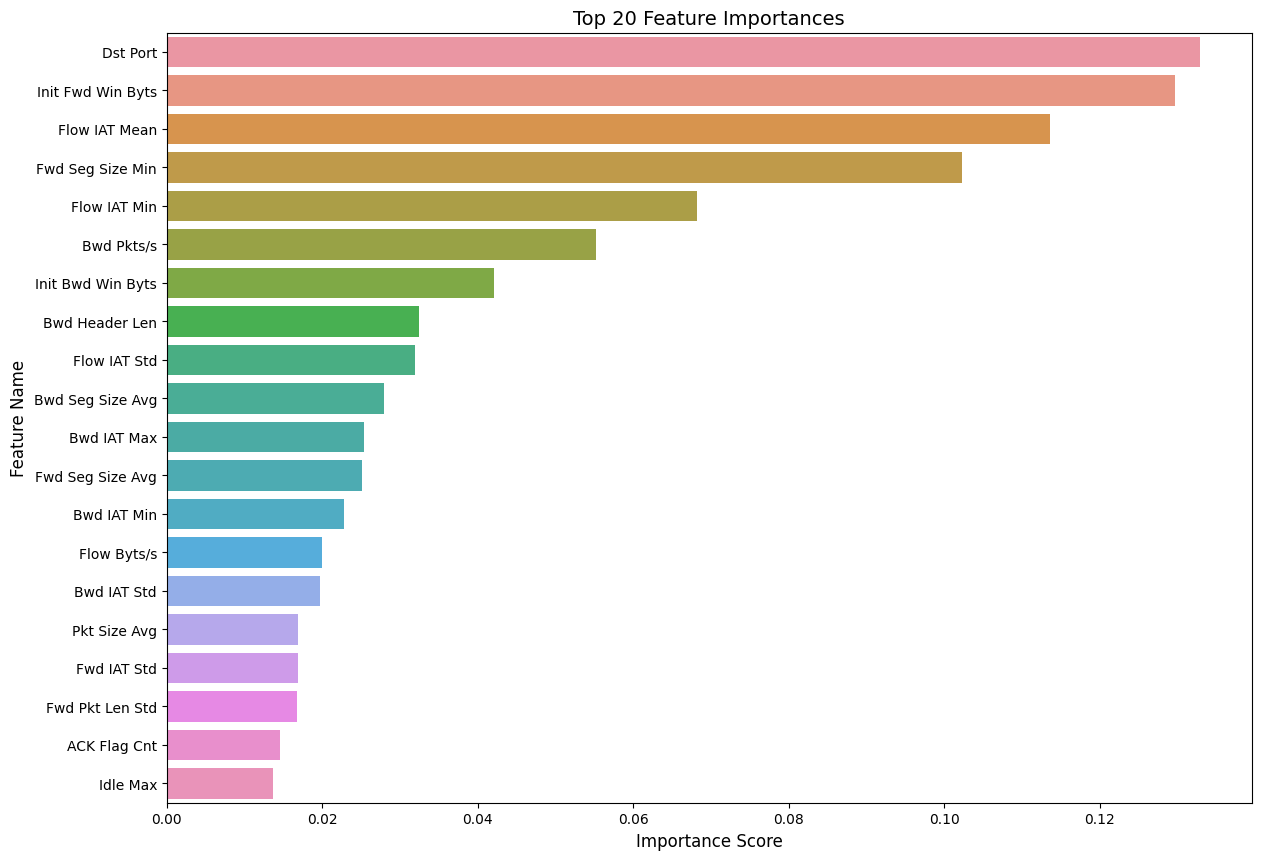


Model Performance Check:
Training Accuracy: 0.9441
Test Accuracy:     0.8949


In [39]:
# First ensure you have these class names defined
class_names = [
    'Benign',
    'Bot',
    'DDOS attack-HOIC',
    'DDoS attacks-LOIC-HTTP',
    'DoS attacks-GoldenEye',
    'DoS attacks-Hulk',
    'DoS attacks-SlowHTTPTest',
    'DoS attacks-Slowloris',
    'FTP-BruteForce',
    'Infilteration',
    'SSH-Bruteforce'
]

# 8. Classification Report (Fixed)
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print("\n8. Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

# 9. Feature Importance Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
feature_importances = model.feature_importances_
feature_names = X.columns  # Original feature names before scaling

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.show()

# Additional check: Training vs Test accuracy
print("\nModel Performance Check:")
print(f"Training Accuracy: {model.score(X_train, y_train):.4f}")
print(f"Test Accuracy:     {model.score(X_test, y_test):.4f}")


----------------------------------------
Training XGBoost
----------------------------------------

Classification Report (XGBoost):
                          precision    recall  f1-score   support

                  Benign     0.7560    0.7143    0.7346      2100
                     Bot     0.9995    0.9986    0.9990      2100
        DDOS attack-HOIC     0.9995    1.0000    0.9998      2100
  DDoS attacks-LOIC-HTTP     1.0000    0.9995    0.9998      2100
   DoS attacks-GoldenEye     1.0000    1.0000    1.0000      2100
        DoS attacks-Hulk     1.0000    0.9995    0.9998      2100
DoS attacks-SlowHTTPTest     0.8098    0.5290    0.6400      2100
   DoS attacks-Slowloris     1.0000    1.0000    1.0000      2100
          FTP-BruteForce     0.6504    0.8762    0.7466      2100
           Infilteration     0.7287    0.7700    0.7488      2100
          SSH-Bruteforce     1.0000    0.9995    0.9998      2100

                accuracy                         0.8988     23100
      

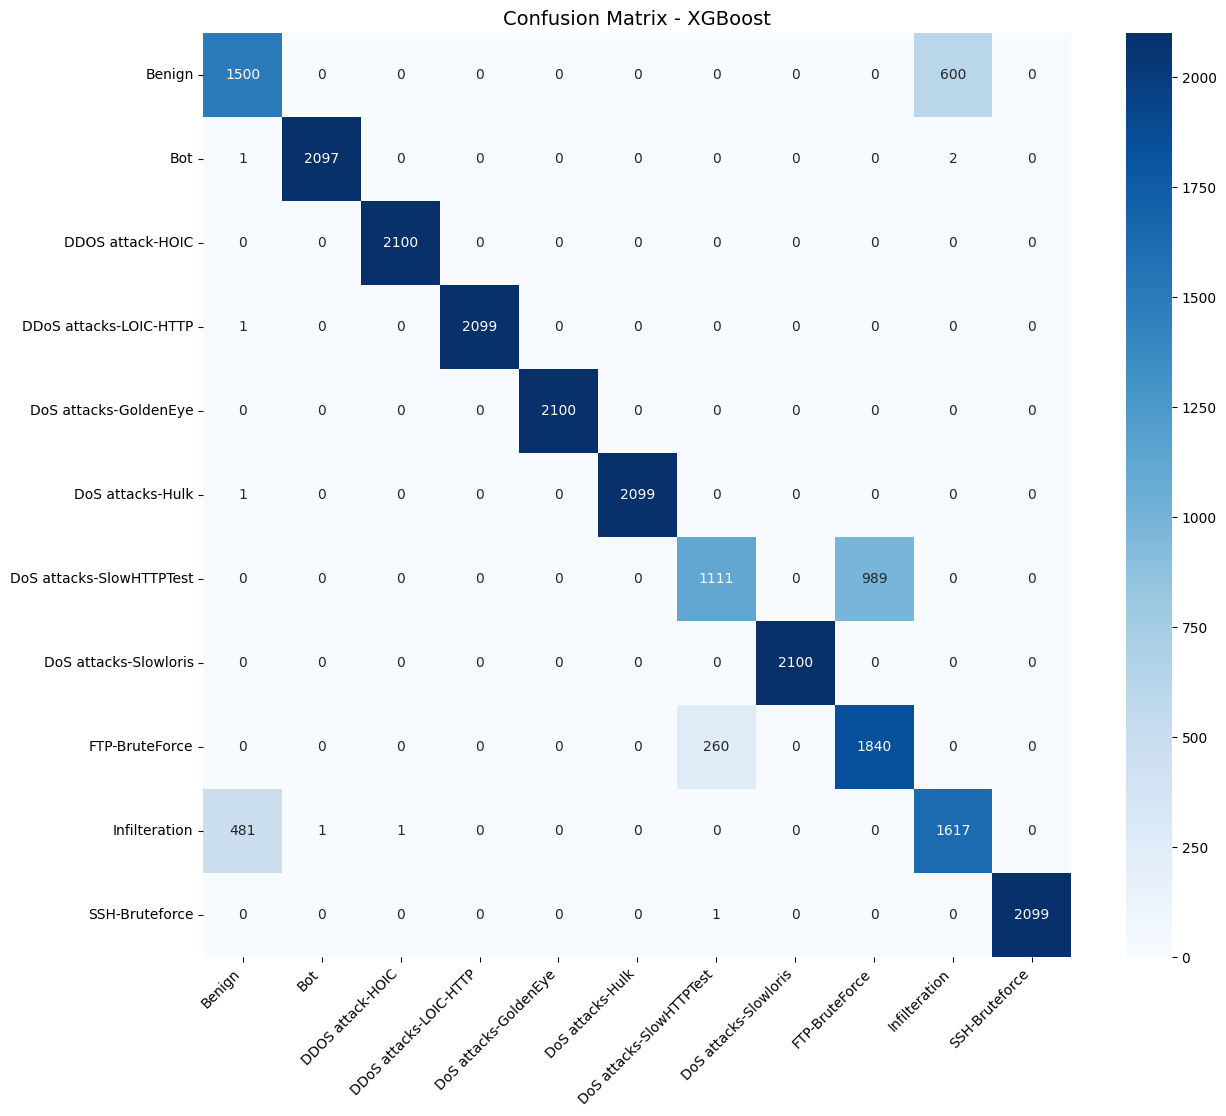

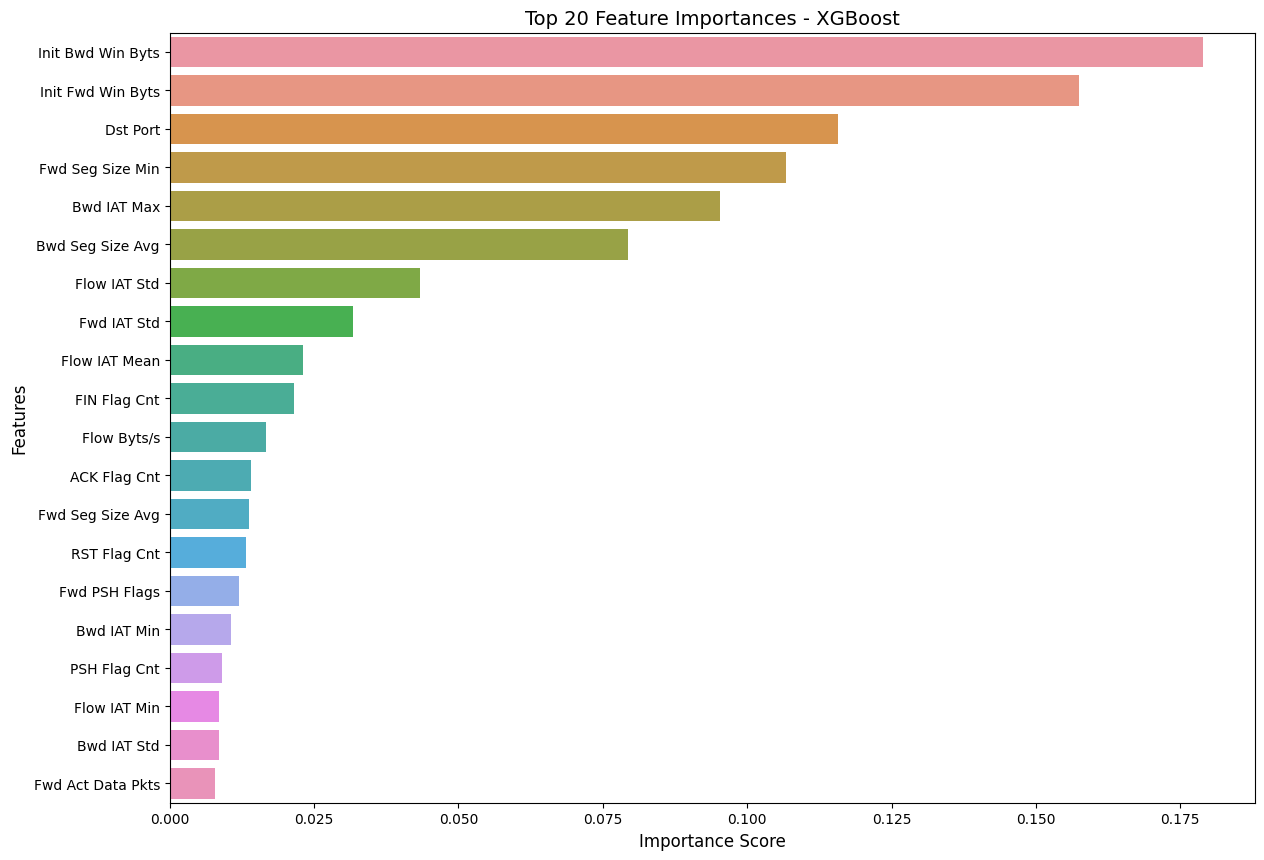


----------------------------------------
Training AdaBoost
----------------------------------------

Classification Report (AdaBoost):
                          precision    recall  f1-score   support

                  Benign     0.4571    0.0076    0.0150      2100
                     Bot     0.7234    0.9986    0.8390      2100
        DDOS attack-HOIC     0.3595    1.0000    0.5289      2100
  DDoS attacks-LOIC-HTTP     0.0000    0.0000    0.0000      2100
   DoS attacks-GoldenEye     0.0000    0.0000    0.0000      2100
        DoS attacks-Hulk     0.3331    0.9943    0.4990      2100
DoS attacks-SlowHTTPTest     0.0000    0.0000    0.0000      2100
   DoS attacks-Slowloris     0.0000    0.0000    0.0000      2100
          FTP-BruteForce     0.0000    0.0000    0.0000      2100
           Infilteration     0.1182    0.4533    0.1875      2100
          SSH-Bruteforce     0.0000    0.0000    0.0000      2100

                accuracy                         0.3140     23100
    

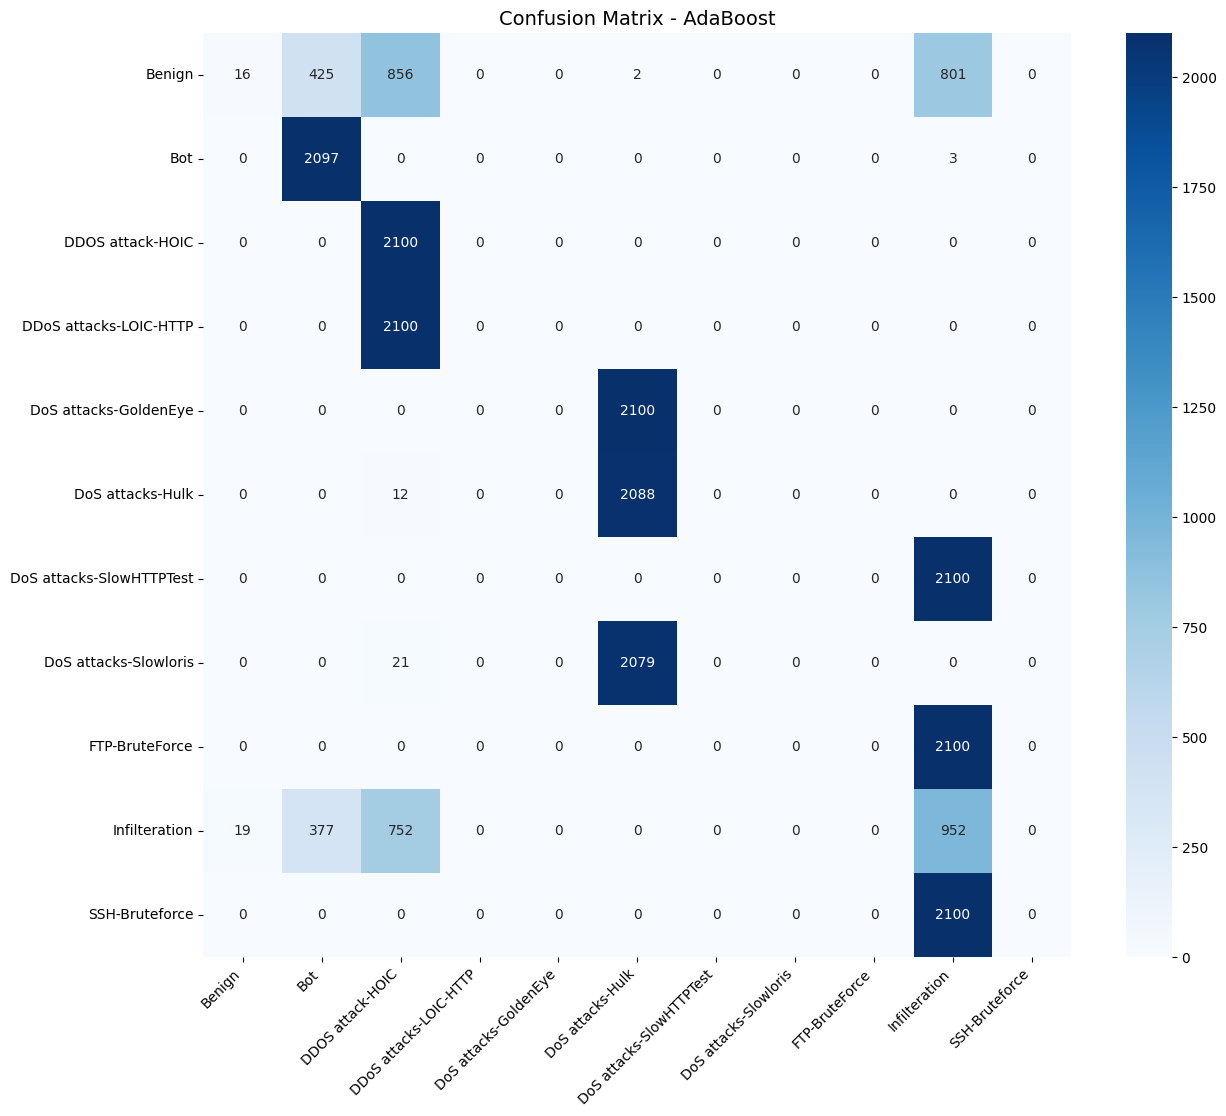

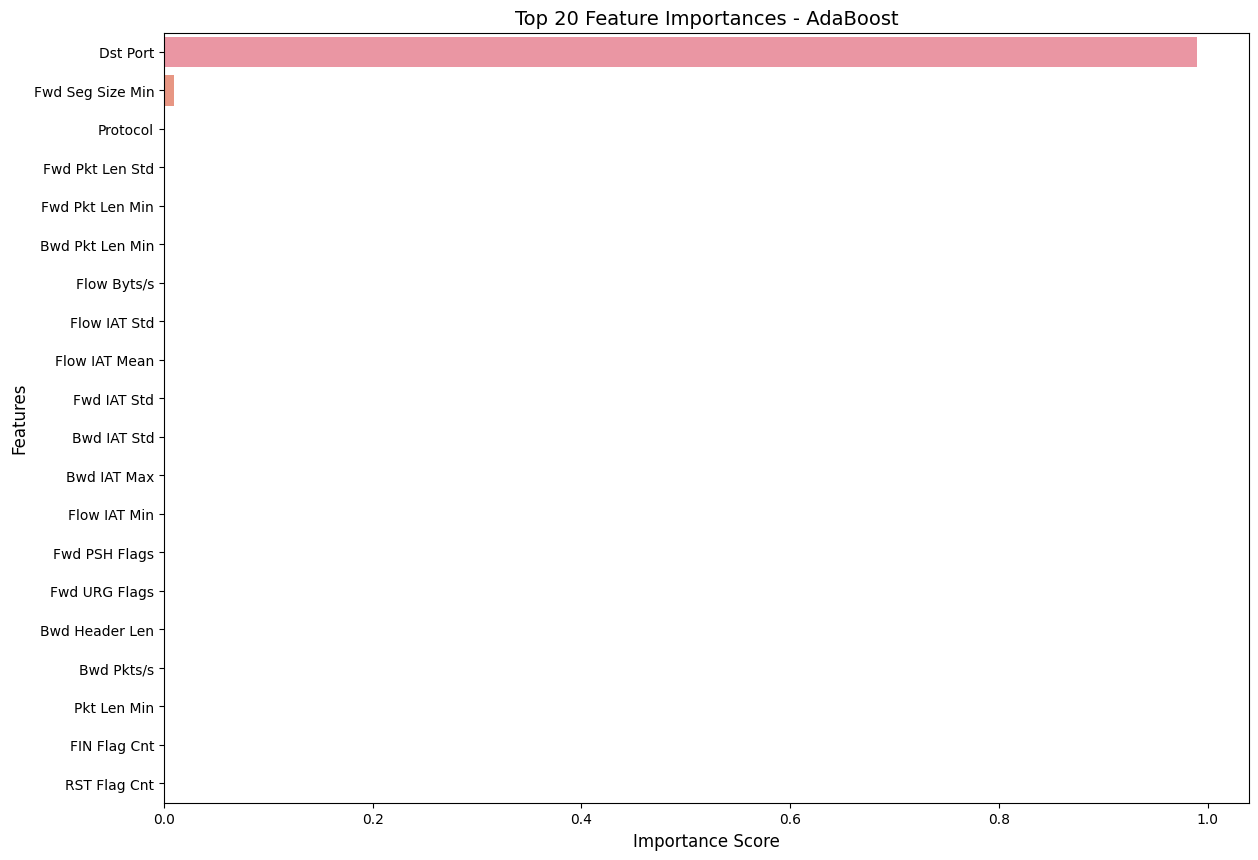


----------------------------------------
Training LightGBM
----------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6147
[LightGBM] [Info] Number of data points in the train set: 92400, number of used features: 37
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[Light

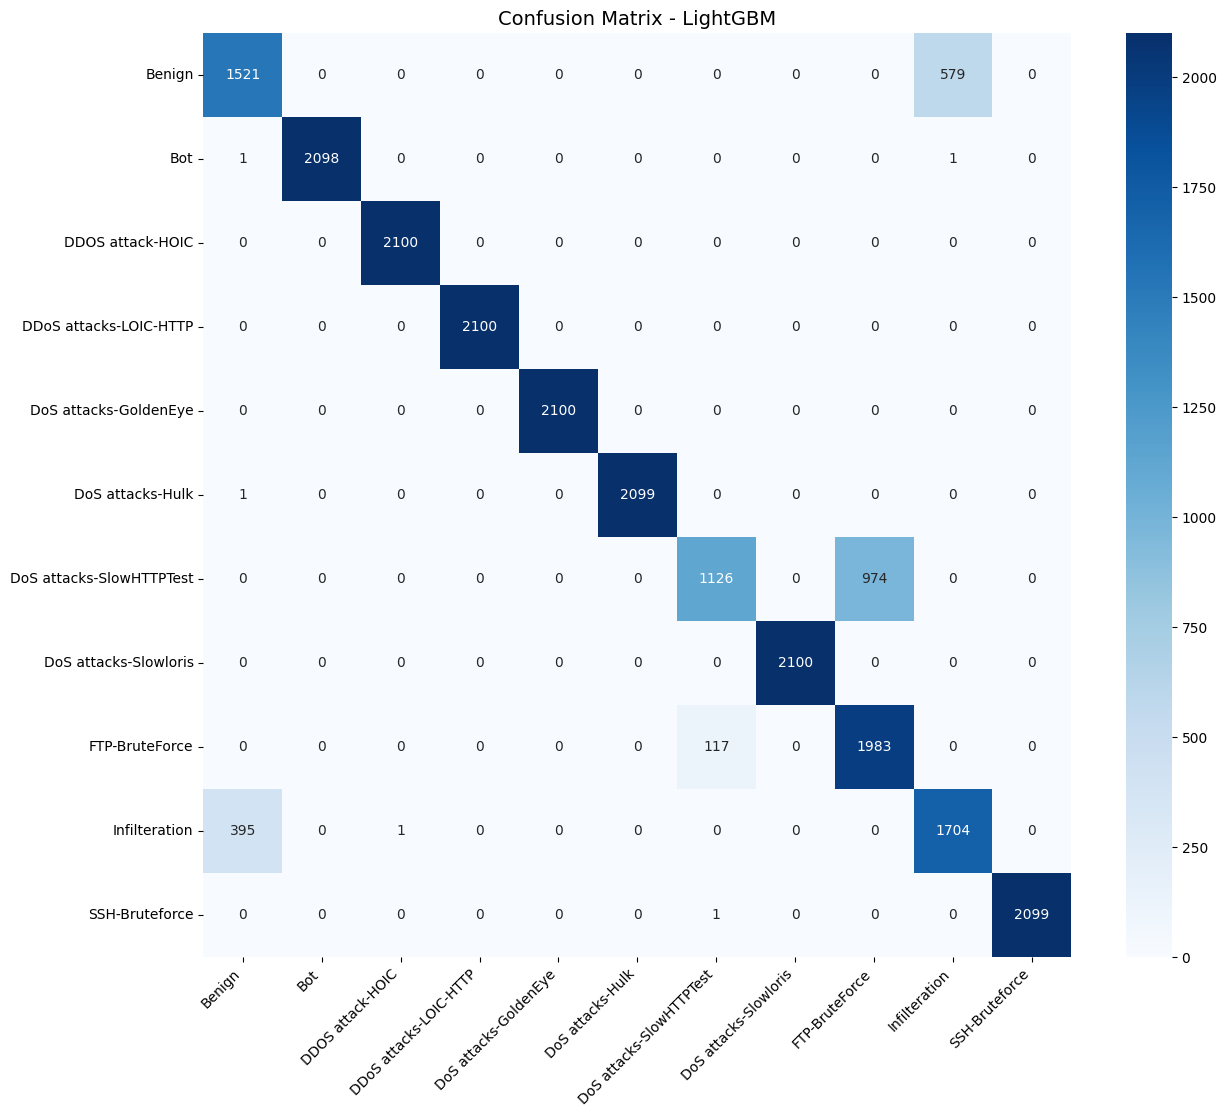

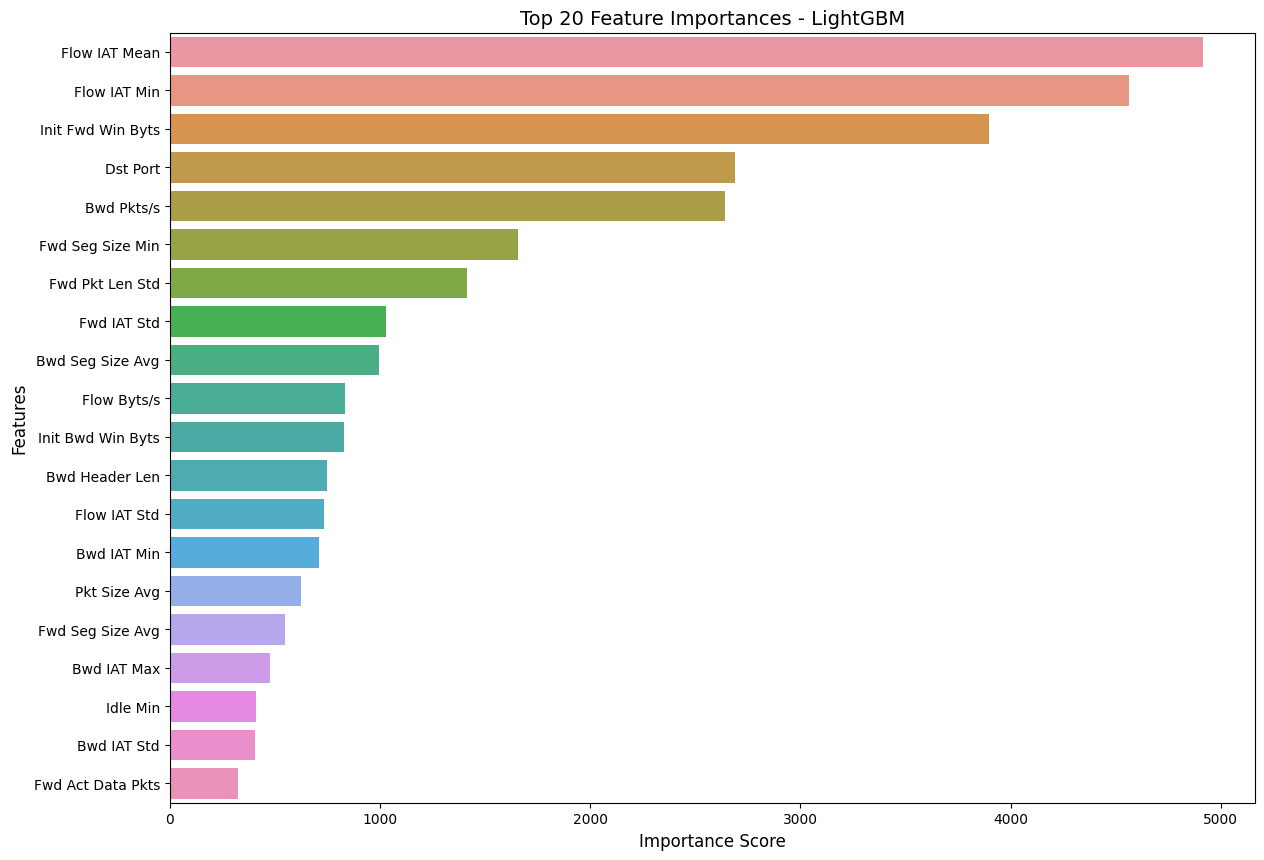


----------------------------------------
Training Extra Trees
----------------------------------------

Classification Report (Extra Trees):
                          precision    recall  f1-score   support

                  Benign     0.7195    0.7110    0.7152      2100
                     Bot     1.0000    0.9995    0.9998      2100
        DDOS attack-HOIC     1.0000    1.0000    1.0000      2100
  DDoS attacks-LOIC-HTTP     0.9995    1.0000    0.9998      2100
   DoS attacks-GoldenEye     1.0000    1.0000    1.0000      2100
        DoS attacks-Hulk     1.0000    1.0000    1.0000      2100
DoS attacks-SlowHTTPTest     0.8070    0.5295    0.6394      2100
   DoS attacks-Slowloris     1.0000    1.0000    1.0000      2100
          FTP-BruteForce     0.6500    0.8738    0.7455      2100
           Infilteration     0.7144    0.7229    0.7186      2100
          SSH-Bruteforce     1.0000    0.9995    0.9998      2100

                accuracy                         0.8942     2310

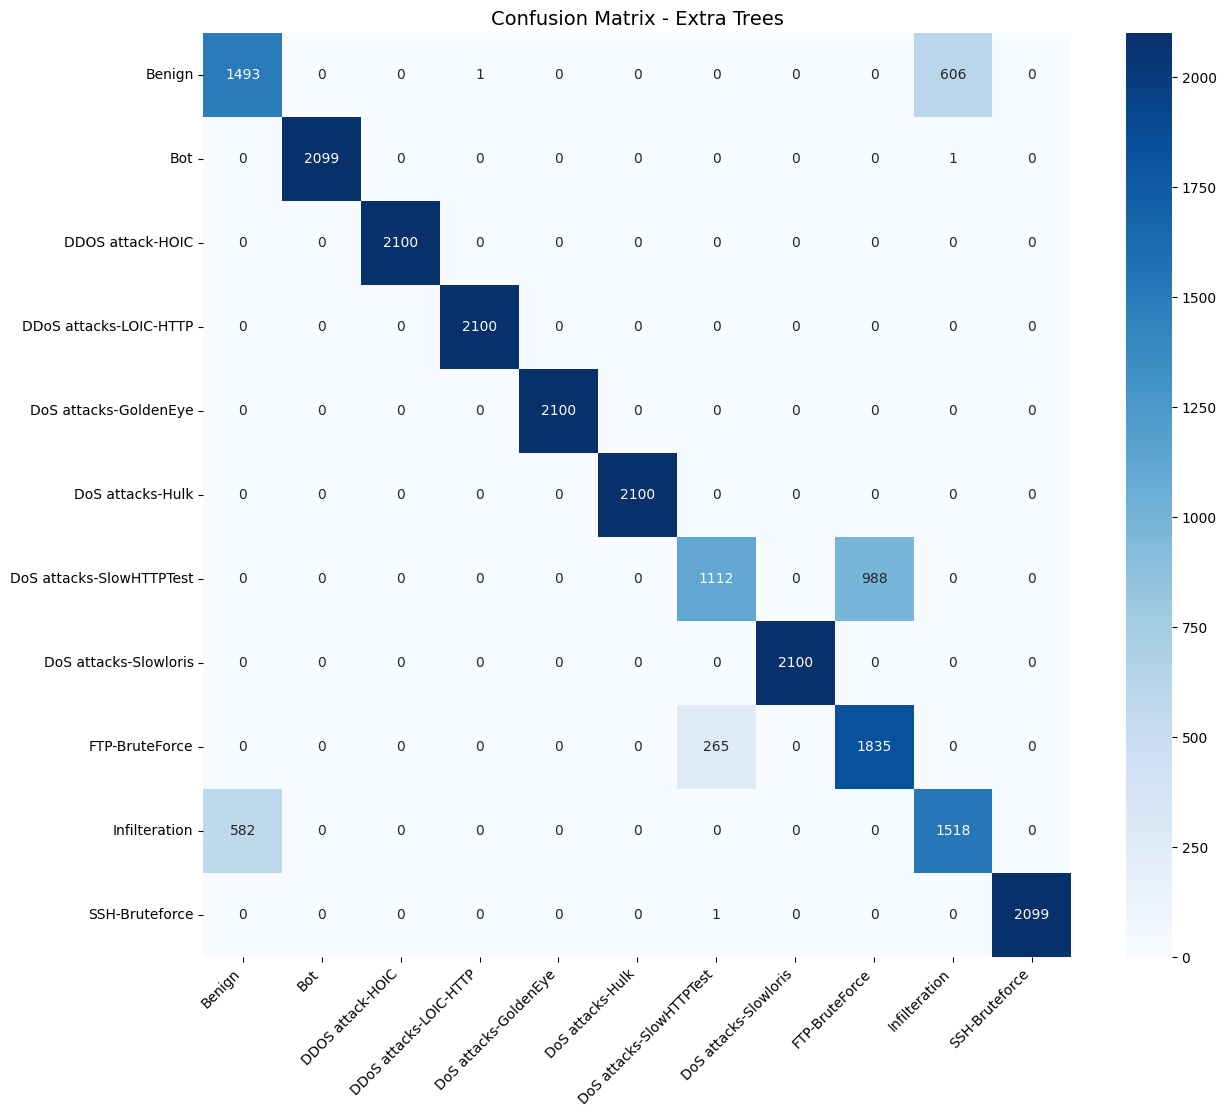

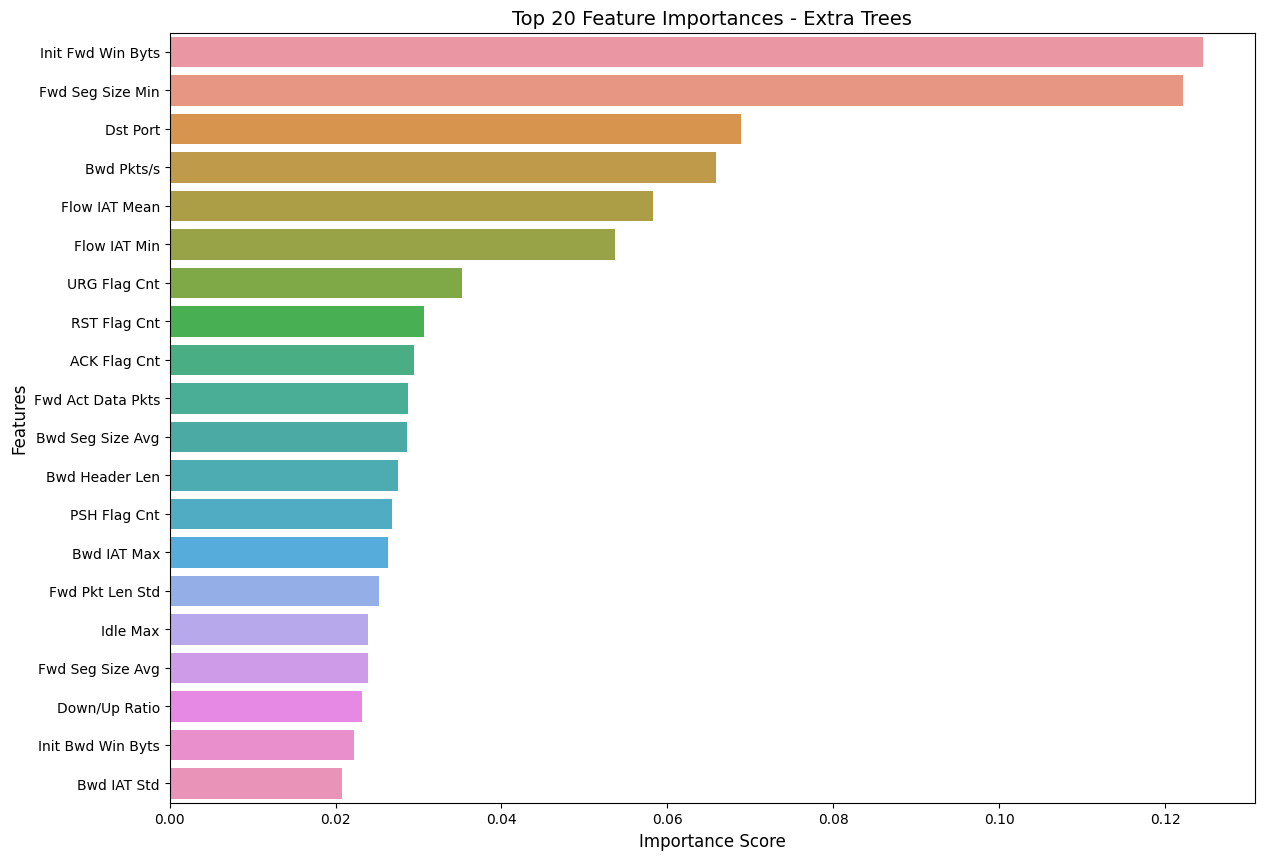


Model Comparison:
             Training Accuracy  Test Accuracy  Training Time (s)
XGBoost               0.916006       0.898788           6.145677
AdaBoost              0.315325       0.313983          12.095983
LightGBM              0.923820       0.910390           8.379503
Extra Trees           0.944123       0.894199           5.191204


In [40]:
import time
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Install required packages (uncomment if needed)
#!pip install xgboost lightgbm

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier

# Define class names
class_names = [
    'Benign',
    'Bot',
    'DDOS attack-HOIC',
    'DDoS attacks-LOIC-HTTP',
    'DoS attacks-GoldenEye',
    'DoS attacks-Hulk',
    'DoS attacks-SlowHTTPTest',
    'DoS attacks-Slowloris',
    'FTP-BruteForce',
    'Infilteration',
    'SSH-Bruteforce'
]

# Initialize models
models = {
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n{'-'*40}")
    print(f"Training {name}")
    print(f"{'-'*40}")
    
    start_time = time.time()
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Timing
    training_time = time.time() - start_time
    
    # Store results
    results[name] = {
        'model': model,
        'train_acc': model.score(X_train, y_train),
        'test_acc': model.score(X_test, y_test),
        'time': training_time
    }
    
    # Classification report
    print(f"\nClassification Report ({name}):")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))
    
    # Confusion matrix
    plt.figure(figsize=(14, 12))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=class_names,
                yticklabels=class_names,
                cmap='Blues')
    plt.title(f'Confusion Matrix - {name}', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.show()
    
    # Feature importance (where applicable)
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(14, 10))
        feature_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)[:20]
        sns.barplot(x=feature_imp.values, y=feature_imp.index)
        plt.title(f'Top 20 Feature Importances - {name}', fontsize=14)
        plt.xlabel('Importance Score', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.show()

# Compare model performances
print("\nModel Comparison:")
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df[['train_acc', 'test_acc', 'time']]
results_df.columns = ['Training Accuracy', 'Test Accuracy', 'Training Time (s)']
print(results_df)

In [41]:
!pip install pykan torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 3.3 MB/s eta 0:00:00



Classification Report (LSTM):
                          precision    recall  f1-score   support

                  Benign     0.6159    0.8238    0.7048      2100
                     Bot     0.9986    0.9995    0.9990      2100
        DDOS attack-HOIC     1.0000    1.0000    1.0000      2100
  DDoS attacks-LOIC-HTTP     1.0000    0.9981    0.9990      2100
   DoS attacks-GoldenEye     0.9995    1.0000    0.9998      2100
        DoS attacks-Hulk     0.9995    1.0000    0.9998      2100
DoS attacks-SlowHTTPTest     0.7208    0.5286    0.6099      2100
   DoS attacks-Slowloris     1.0000    1.0000    1.0000      2100
          FTP-BruteForce     0.6276    0.7952    0.7015      2100
           Infilteration     0.7376    0.4886    0.5878      2100
          SSH-Bruteforce     1.0000    0.9995    0.9998      2100

                accuracy                         0.8758     23100
               macro avg     0.8818    0.8758    0.8729     23100
            weighted avg     0.8818    0.87

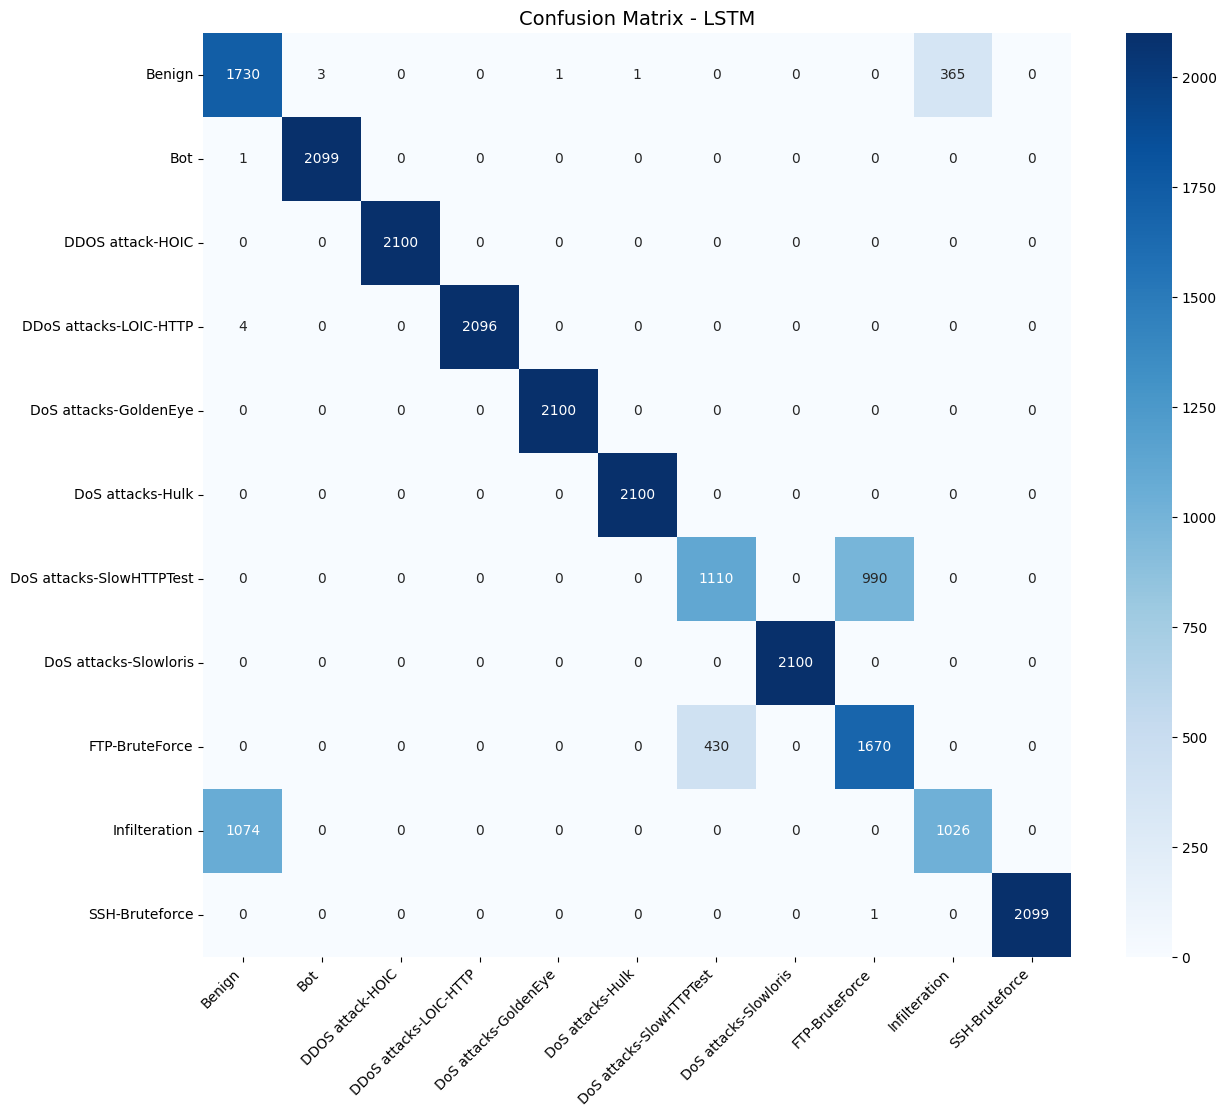


Updated Model Comparison:
             Training Accuracy  Test Accuracy  Training Time (s)
XGBoost               0.916006       0.898788           6.145677
AdaBoost              0.315325       0.313983          12.095983
LightGBM              0.923820       0.910390           8.379503
Extra Trees           0.944123       0.894199           5.191204
LSTM                  0.876602       0.875758          71.159861


In [49]:
# Add these imports at the top with other imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import numpy as np

# Add this after your existing model comparison code
# Convert data to PyTorch tensors (proper handling of pandas Series)
X_train_tensor = torch.FloatTensor(X_train.values if hasattr(X_train, 'values') else X_train)
X_test_tensor = torch.FloatTensor(X_test.values if hasattr(X_test, 'values') else X_test)
y_train_tensor = torch.LongTensor(y_train.to_numpy() if hasattr(y_train, 'to_numpy') else y_train)
y_test_tensor = torch.LongTensor(y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test)

# Rest of the LSTM code remains the same...
# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# LSTM Model Definition
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Add sequence dimension (seq_len=1 for tabular data)
        x = x.unsqueeze(1)  
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Model configuration
input_size = X_train.shape[1]
hidden_size = 128
num_classes = len(class_names)

model = LSTMClassifier(input_size, hidden_size, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

training_time = time.time() - start_time

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
y_pred = np.array(all_preds)
y_true = np.array(all_labels)

# Store results
train_preds = model(X_train_tensor.to(device)).argmax(1).cpu().numpy()
results["LSTM"] = {
    'model': model,
    'train_acc': accuracy_score(y_train.to_numpy() if hasattr(y_train, 'to_numpy') else y_train, train_preds),
    'test_acc': accuracy_score(y_true, y_pred),
    'time': training_time
}

# Classification Report
print("\nClassification Report (LSTM):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion Matrix
plt.figure(figsize=(14, 12))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.title('Confusion Matrix - LSTM', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

# Update model comparison
print("\nUpdated Model Comparison:")
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df[['train_acc', 'test_acc', 'time']]
results_df.columns = ['Training Accuracy', 'Test Accuracy', 'Training Time (s)']
print(results_df)

In [51]:
from sklearn.linear_model import LogisticRegression  # Add this import
from sklearn.ensemble import StackingClassifier

# Best base models
estimators = [
    ('xgb', XGBClassifier(n_estimators=100, eval_metric='mlogloss')),
    ('lgbm', LGBMClassifier(n_estimators=150)),
    ('et', ExtraTreesClassifier(n_estimators=200))
]

# Final meta-model
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
    cv=5
)

stack.fit(X_train, y_train)
print(f"Stacked Test Accuracy: {stack.score(X_test, y_test):.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6147
[LightGBM] [Info] Number of data points in the train set: 92400, number of used features: 37
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Warning] No further splits with positive 

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 20],  # Control overfitting
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 0.5],  # Reduced from default 'auto'
    'bootstrap': [True, False]  # Try both with and without bootstrap
}

# Initialize and tune model
et = ExtraTreesClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(et, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model
best_et = grid_search.best_estimator_

# Evaluate
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Train Accuracy: {best_et.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {best_et.score(X_test, y_test):.4f}")

# Feature Importance Visualization
plt.figure(figsize=(12, 8))
importances = best_et.feature_importances_
sorted_idx = importances.argsort()[::-1][:20]  # Top 20 features
plt.barh(range(20), importances[sorted_idx][::-1], align='center')
plt.yticks(range(20), X.columns[sorted_idx][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Features - Tuned ExtraTrees")
plt.show()

Fitting 3 folds for each of 72 candidates, totalling 216 fits
